In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout,BatchNormalization
from keras.models import Sequential
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import os
import autokeras as ak
import keras
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
import pickle
import time
from matplotlib.animation import FuncAnimation
from joblib import dump, load
from pandas.core.computation.check import NUMEXPR_INSTALLED

In [3]:
class ExtruderController():
    def __init__(self,screwspeed,solidcontent,massflow_ref,Energy_ref,Torque_ref):
        self.z = 0
        self.x = 1 
        self.screwspeed_epsilon = 20          #80
        self.screwspeed_etha = 20             #80
        self.solidcontent_epsilon= 1          #2.5
        self.solidcontent_etha = 1            #2.5
#get Data
        self.screwspeed=screwspeed            # float(input("enter the value of screwspeed"))
        self.solidcontent=solidcontent       #float(input("enter the value of solidcontent"))
        self.massflow_ref=massflow_ref       #float(input("enter the value of massflow_ref"))
        self.Energy_ref=Energy_ref           #float(input("enter the desired value of Energy_ref"))
        self.Torque_ref=Torque_ref           #float(input("enter the desired value of Torque_ref"))
        self.Energy_list=[]
        self.Torque_list=[]
        self.screwspeed_list=[]
        self.solidcontent_list=[]
            
#unitlity function --> dont get self --> @staticmethod
#Extruder function get [masflow_ref,screwspeed,solidcontent] and return [self.Energy_pred, self.Torque_pred]  
    def Extruder(self):
        print('inside Extruder')
        print(f'screwspeed:{self.screwspeed:}, solidcontent:{self.solidcontent:}')
#prepare inputs 
        input_Extruder=np.array([[self.massflow_ref,self.screwspeed,self.solidcontent]], dtype=object)  
        self.screwspeed_list.append(self.screwspeed)
        self.solidcontent_list.append(self.solidcontent)       
#predict Energy-pred
        model_Energy=load('model_Energy.h5')  
        self.Energy_pred = model_Energy.predict(input_Extruder)
        self.Energy_list.append(self.Energy_pred)    
#predict Torque_pred
        model_Torque=load('model_Torque.h5')  
        self.Torque_pred = model_Torque.predict(input_Extruder)
        self.Torque_list.append(self.Torque_pred)
        print(self.Energy_pred, self.Torque_pred)
              
#         fig,ax=plt.subplots(2,2,figsize=(10,10))
#         self.line,=ax[0,0].plot(self.screwspeed,Energy)

#     def animation_frame():
#         self.screwspeed_list.append(self.screwspeed)
#         self.Energy_list.append(self.Energy_pred)
#         self.line.set_xdata()
#         self.line.set_ydata()
#         return self.line,
    
# check Convergence:
    def coarse_criterion(self):
        print('inside coarse criterion')
        if self.z==0:
            if 0.9*self.Energy_ref<self.Energy_pred<1.1*self.Energy_ref and 0.9*self.Torque_ref<self.Torque_pred<1.1*self.Torque_ref:
                self.screwspeed_fin=self.screwspeed
                self.solidcontent_fin=self.solidcontent
                self.z=1
                return True
            else:
                return False   
        else:#self.z!=0
            return True
                    
    def fine_criterion(self):
        print('inside fine criterion')
        if 0.99*self.Energy_ref<self.Energy_pred<1.01*self.Energy_ref and 0.99*self.Torque_ref<self.Torque_pred<1.01*self.Torque_ref:
            print("everything is in the required range!")
            return True 
        else:
            return False 
        
        
    def screwspeed_update(self):
        print('inside screwspeed_update')#z,screwspeed_epsilon,screwspeed_etha,screwspeed_fin
        if self.z==1:
            if self.screwspeed_epsilon>80:
                print("we should go to solidcontent_update now:",self.screwspeed_epsilon)
                self.solidcontent_update()
            else:
                
                self.screwspeed=self.screwspeed_fin+self.screwspeed_epsilon
                print("final1 self.screwspeed to enter solidcontent_update:",self.screwspeed)
                print(self.z)
                self.screwspeed_epsilon=self.screwspeed_epsilon+20
                self.z=2
            
        else:
            if self.screwspeed_etha>80:
                print("we should go to solidcontent_update now:",self.screwspeed_etha)
                self.solidcontent_update()
            else:
                
                self.screwspeed=self.screwspeed_fin-self.screwspeed_etha
                print("final self.screwspeed to enter solidcontent_update:",self.screwspeed)
                self.screwspeed_etha=self.screwspeed_etha+20
                self.z=1
           
            
    def solidcontent_update(self):#x,solidcontent_epsilon,solidcontent_etha,solidcontent_fin
        print('inside solidcontent_update')
        print("screwspeed_fin+",self.screwspeed_fin)
        if self.x==1:
            if self.solidcontent_epsilon>5:
                print("Divergence occured!")
                exit()
            self.solidcontent=self.solidcontent_fin+self.solidcontent_epsilon
            self.solidcontent_epsilon=self.solidcontent_epsilon+1 
            self.screwspeed_epsilon=20
            self.screwspeed_etha=20
            self.x=2
            self.z=1
            self.screwspeed_update()           
        else:
            if self.solidcontent_etha>5:
                print("Divergence occured!")
                exit()
                
            self.solidcontentt=self.solidcontent_fin-self.solidcontent_etha
            self.solidcontent_etha=self.solidcontent_etha+1
            self.screwspeed_epsilon=20
            self.screwspeed_etha=20
            self.x=1
            self.screwspeed__update()
            
            
#neuroController function gets massflow_ref, Energy_ref, Torque_ref, Energy_pred, Torque_pred
#and returns[self.Delta_screwspeed_pred,self.Delta_solidcontroler_pred]          
    def neuroController(self):                 
        print('inside neurocontroller')
        # prepare inputs 
        input_NC=np.array([[self.massflow_ref, self.Energy_ref, self.Torque_ref,self.Energy_pred,self.Torque_pred]], dtype=object)
        #predict Delta_screwspeed_pred
        model_Dn_Neurocontroller=load('model_Dn_Neurocontroller.h5')  
        Delta_screwspeed_pred=pd.DataFrame(model_Dn_Neurocontroller.predict(input_NC))
        #predict cm_Neurocontroller
        model_cm_Neurocontroller=load('model_cm_Neurocontroller.h5')  
        Delta_solidcontent_pred = pd.DataFrame(model_cm_Neurocontroller.predict(input_NC))
    
        self.Delta_screwspeed_pred=model_Dn_Neurocontroller.predict(input_NC)
        self.Delta_solidcontent_pred=model_cm_Neurocontroller.predict(input_NC)
        print(self.Delta_screwspeed_pred,self.Delta_solidcontent_pred)        

#updat function get the Delta_screwspeed_pred,Delta_solidcontent_pred
#and add them to the previous screwspeed and solidcontroler so it 
#returnes new screwspeed, solidcontroler values
    def update(self):
        print('inside update')
        self.screwspeed=self.screwspeed+self.Delta_screwspeed_pred
        self.solidcontent=self.solidcontent+self.Delta_solidcontent_pred
        print(self.screwspeed, self.solidcontent)
        
    def start_process(self):
        self.plot_array=np.array([[]])
        while True:
            j=1
            
            self.Extruder()
            if self.coarse_criterion():
                while True:
                    if j >15:
                        break
                
                    if self.fine_criterion():
                        break
                    else:
                        self.screwspeed_update()
                        print(j)
                        j = j+1
                        self.Extruder()
                print('everythinh is in range and final screwspeed and final solidcontent are {} and {} respectively'.format(screwspeed,solidcontent))
                break
            else:
                self.neuroController()
                self.update()
#plt.scatter(self.plot_array[:,0],self.plot_array[:,1])     
            time.sleep(3)
            
            
            
        
        

        

    

In [5]:
screwspeed,solidcontent,massflow_ref,Energy_ref,Torque_ref= 400,70,2.28,6552,2.972

In [6]:
Extruder_Controller=ExtruderController(screwspeed,solidcontent,massflow_ref,Energy_ref,Torque_ref)

In [7]:
Extruder_Controller.start_process()

inside Extruder
screwspeed:400, solidcontent:70
[5829.03778661] [10.58504427]
inside coarse criterion
inside neurocontroller
[36.07574086] [-0.01348615]
inside update
[436.07574086] [69.98651385]
inside Extruder
screwspeed:[436.07574086], solidcontent:[69.98651385]
[5829.03778661] [10.58504427]
inside coarse criterion
inside neurocontroller
[36.07574086] [-0.01348615]
inside update
[472.15148172] [69.97302771]
inside Extruder
screwspeed:[472.15148172], solidcontent:[69.97302771]
[5829.03778661] [10.58504427]
inside coarse criterion
inside neurocontroller
[36.07574086] [-0.01348615]
inside update
[508.22722259] [69.95954156]
inside Extruder
screwspeed:[508.22722259], solidcontent:[69.95954156]
[5829.03778661] [10.58504427]
inside coarse criterion
inside neurocontroller
[36.07574086] [-0.01348615]
inside update
[544.30296345] [69.94605542]
inside Extruder
screwspeed:[544.30296345], solidcontent:[69.94605542]
[5829.03778661] [10.58504427]
inside coarse criterion
inside neurocontroller
[36

inside Extruder
screwspeed:[1770.87815277], solidcontent:[69.48752648]
[5829.03778661] [10.58504427]
inside coarse criterion
inside neurocontroller
[36.07574086] [-0.01348615]
inside update
[1806.95389364] [69.47404034]
inside Extruder
screwspeed:[1806.95389364], solidcontent:[69.47404034]
[5829.03778661] [10.58504427]
inside coarse criterion
inside neurocontroller
[36.07574086] [-0.01348615]
inside update
[1843.0296345] [69.46055419]
inside Extruder
screwspeed:[1843.0296345], solidcontent:[69.46055419]
[5829.03778661] [10.58504427]
inside coarse criterion
inside neurocontroller
[36.07574086] [-0.01348615]
inside update
[1879.10537536] [69.44706805]
inside Extruder
screwspeed:[1879.10537536], solidcontent:[69.44706805]
[5829.03778661] [10.58504427]
inside coarse criterion
inside neurocontroller
[36.07574086] [-0.01348615]
inside update
[1915.18111622] [69.4335819]
inside Extruder
screwspeed:[1915.18111622], solidcontent:[69.4335819]
[5829.03778661] [10.58504427]
inside coarse criterion

inside Extruder
screwspeed:[3141.75630555], solidcontent:[68.97505297]
[5829.03778661] [10.58504427]
inside coarse criterion
inside neurocontroller
[36.07574086] [-0.01348615]
inside update
[3177.83204641] [68.96156682]
inside Extruder
screwspeed:[3177.83204641], solidcontent:[68.96156682]
[5829.03778661] [10.58504427]
inside coarse criterion
inside neurocontroller
[36.07574086] [-0.01348615]
inside update
[3213.90778727] [68.94808068]
inside Extruder
screwspeed:[3213.90778727], solidcontent:[68.94808068]
[5829.03778661] [10.58504427]
inside coarse criterion
inside neurocontroller
[36.07574086] [-0.01348615]
inside update
[3249.98352814] [68.93459453]
inside Extruder
screwspeed:[3249.98352814], solidcontent:[68.93459453]
[5829.03778661] [10.58504427]
inside coarse criterion
inside neurocontroller
[36.07574086] [-0.01348615]
inside update
[3286.059269] [68.92110839]
inside Extruder
screwspeed:[3286.059269], solidcontent:[68.92110839]
[5829.03778661] [10.58504427]
inside coarse criterion

KeyboardInterrupt: 

In [11]:
massflow_ref=3
screwspeed=900
solidcontent=80
#prepare inputs 
input_Extruder=np.array([[(massflow_ref),(screwspeed),(solidcontent)]], dtype=object)

#predict Energy-pred
model_Energy=load('model_Energy.h5') 
Energy_pred = pd.DataFrame(model_Energy.predict(input_Extruder))
        
#predict Torque_pred
model_Torque=load('model_Torque.h5') 
Torque_pred = pd.DataFrame(model_Torque.predict(input_Extruder))

print(Energy_pred, Torque_pred)
#plot_array=np.array([[Nplant],[Wplant],[SME_pred[0]], [T_pred[0]]])
plot_array=np.array([])
plot_array= np.append(plot_array,[[screwspeed],[solidcontent],[Energy_pred], [Torque_pred]] )

plot_array

             0
0  5829.037787            0
0  10.585044


C:\Users\Mahtab\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:1859: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


array([900, 80,              0
                0  5829.037787,            0
                                0  10.585044], dtype=object)

In [12]:
Extruder_Controller.start_process()

inside Extruder
screwspeed:[4296.18001315], solidcontent:[68.54349632]
[5829.03778661] [10.58504427]
inside coarse criterion
inside neurocontroller
[36.07574086] [-0.01348615]
inside update
[4332.25575401] [68.53001018]
inside Extruder
screwspeed:[4332.25575401], solidcontent:[68.53001018]
[5829.03778661] [10.58504427]
inside coarse criterion
inside neurocontroller
[36.07574086] [-0.01348615]
inside update
[4368.33149487] [68.51652403]
inside Extruder
screwspeed:[4368.33149487], solidcontent:[68.51652403]
[5829.03778661] [10.58504427]
inside coarse criterion
inside neurocontroller
[36.07574086] [-0.01348615]
inside update
[4404.40723573] [68.50303789]
inside Extruder
screwspeed:[4404.40723573], solidcontent:[68.50303789]
[5829.03778661] [10.58504427]
inside coarse criterion
inside neurocontroller
[36.07574086] [-0.01348615]
inside update
[4440.4829766] [68.48955174]
inside Extruder
screwspeed:[4440.4829766], solidcontent:[68.48955174]
[5829.03778661] [10.58504427]
inside coarse criteri

KeyboardInterrupt: 

In [13]:
Energy= np.array(Extruder_Controller.Energy_list).ravel()
Torque= np.array(Extruder_Controller.Torque_list).ravel()
Screwspeed= np.array(Extruder_Controller.screwspeed_list).ravel()
Solidcontent= np.array(Extruder_Controller.solidcontent_list).ravel()
iteration=list(range(len(Energy)))

<ipython-input-13-f669828de54b>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Screwspeed= np.array(Extruder_Controller.screwspeed_list).ravel()
<ipython-input-13-f669828de54b>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Solidcontent= np.array(Extruder_Controller.solidcontent_list).ravel()


In [14]:
Energy

array([5829.03778661, 5829.03778661, 5829.03778661, 5829.03778661,
       5829.03778661, 5829.03778661, 5829.03778661, 5829.03778661,
       5829.03778661, 5829.03778661, 5829.03778661, 5829.03778661,
       5829.03778661, 5829.03778661, 5829.03778661, 5829.03778661,
       5829.03778661, 5829.03778661, 5829.03778661, 5829.03778661,
       5829.03778661, 5829.03778661, 5829.03778661, 5829.03778661,
       5829.03778661, 5829.03778661, 5829.03778661, 5829.03778661,
       5829.03778661, 5829.03778661, 5829.03778661, 5829.03778661,
       5829.03778661, 5829.03778661, 5829.03778661, 5829.03778661,
       5829.03778661, 5829.03778661, 5829.03778661, 5829.03778661,
       5829.03778661, 5829.03778661, 5829.03778661, 5829.03778661,
       5829.03778661, 5829.03778661, 5829.03778661, 5829.03778661,
       5829.03778661, 5829.03778661, 5829.03778661, 5829.03778661,
       5829.03778661, 5829.03778661, 5829.03778661, 5829.03778661,
       5829.03778661, 5829.03778661, 5829.03778661, 5829.03778

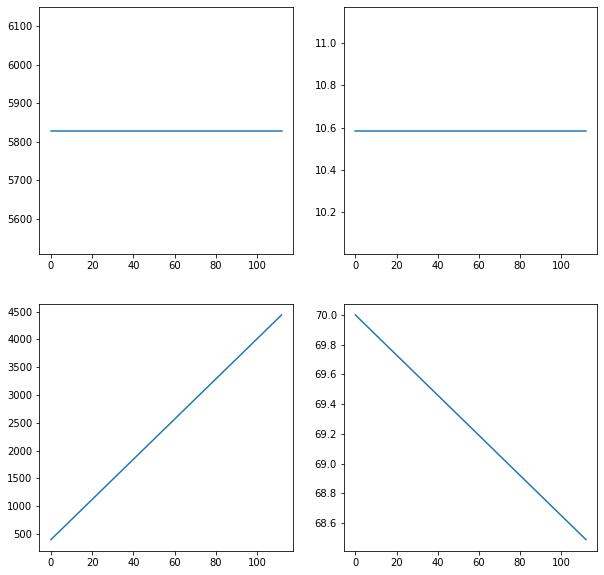

In [15]:
fig,ax=plt.subplots(2,2,figsize=(10,10))
ax[0,0].plot(iteration,Energy)
ax[0,1].plot(iteration,Torque)
ax[1,0].plot(iteration,Screwspeed)
ax[1,1].plot(iteration,Solidcontent)

In [16]:
print(plot_array)

[900 80              0
        0  5829.037787            0
                       0  10.585044]


In [17]:
print(Extruder_Controller.start_process(), name of function , interval=1000)

SyntaxError: invalid syntax (<ipython-input-17-30c82e9c7cd4>, line 1)

In [79]:
ani=FuncAnimation(plt.gcf(), function, interval)

NameError: name 'function' is not defined

<Figure size 432x288 with 0 Axes>

In [1]:

 v o id Check ( )
 {
        i f ( z == 0 )
        {
         i f (SME < ( 1 . 1 ∗SMEREF) and SME > ( 0 . 9 ∗SMEREF) and M < ( 1 . 1 ∗MREF) and M > ( 0 . 9 ∗MREF) )
         {
             N f in = Np lant ;
             Wfin = Wplant ;
             z = 1 ;
             Nupdate ( ) ;
         }
         N e u r o c o n t r o l l e r ( ) ;
        }
     
        i f (SME < ( 1 . 0 1 ∗SMEREF) and SME > ( 0 . 9 9 ∗SMEREF) and M < ( 1 . 0 1 ∗MREF) and M > ( 0 . 9 9 ∗MREF) )
        {
         ExitMemBrain ( ) ;
        }
        Nupdate ( ) ;
 }

    
    
186 N e u r o c o n t r o l l e r ( ) ;
187 }
188 i f (SME < ( 1 . 0 1 ∗SMEREF) and SME > ( 0 . 9 9 ∗SMEREF) and M < ( 1 . 0 1 ∗MREF) and M > ( 0 . 9 9 ∗MREF) )
189 {
190 ExitMemBrain ( ) ;
191 }
192 N

SyntaxError: invalid syntax (<ipython-input-1-e32f8899cb80>, line 1)